YouTube Link: https://youtu.be/eyDIkYAFFrg

In [ ]:
#@title Code: Run this cell to install  dependencies
## install libraries

!pip install google-cloud-aiplatform --upgrade --quiet

!pip install google-cloud-core --quiet
!pip install youtube-transcript-api --quiet
!pip install tensorflow-text --quiet
!pip install nltk --quiet








**Restart runtime after the above installs**

In [1]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [22]:
#@title Code: Run this cell to  import dependencies


## import
from youtube_transcript_api import YouTubeTranscriptApi
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
# from google.cloud import aiplatform
# from google.cloud.aiplatform.private_preview.language_models import TextGenerationModel, ChatModel, TextEmbeddingModel

from IPython.display import HTML, display
#required for generating embeddings
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
from numpy import dot
from numpy.linalg import norm
import numpy as np
import math
from IPython.display import YouTubeVideo

#for preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
vertexai.init(project="<ENTER YOUR PROJECT ID>", location="us-central1")



def predict_large_language_model_sample(
    content: str,
    temperature: float,
    max_decode_steps: int,
    top_p: float,
    top_k: int,
    ):
  parameters = {
    "temperature": temperature,
    "max_output_tokens": max_decode_steps,
    "top_p": top_p,
    "top_k": top_k
  }
  model = TextGenerationModel.from_pretrained("text-bison@001")
  response = model.predict(content, **parameters)

  return response.text


In [7]:
#@title You can keep this parameters as default or experiment with the values

temperature = 0.2 # @param {type:"number"}
max_decode_steps = 1024 # @param {type:"number"}
top_p = 0.95 # @param {type:"number"}
top_k = 40 # @param {type:"number"}

## Helper Functions

In [8]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


def get_transcript(video_id):
  transcript = YouTubeTranscriptApi.get_transcript(video_id)
  merged_text = " ".join([t['text'] for t in transcript]).replace("\n", " ")

  return merged_text


def remove_stop_words(input_text:str) -> str:
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(input_text)

  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

  return " ".join(filtered_sentence)

def get_embeddings_for_transcript(video_id):
  _transcript = YouTubeTranscriptApi.get_transcript(video_id)

  #load the embedding model from tensorflow hub
  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  #nj#embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")


  _embedded_transcript = []

  line_count = 0
  line = ''
  line_start = 0
  line_processed = 0
  NUM_LINES = 4
  prev_line = ''

  #generate embeddings for the entire transcripts
  for t in _transcript:
    line_processed = line_processed + 1

    if line_count != NUM_LINES:
      line_count = line_count + 1 #increase the line count till it reaches NUM_LINES
      line = line + ' ' + t['text'] # append the lines

    if line_count == 1: #note the start for first line
      line_start = t['start']

    #on reaching NUM_LINES or the last line in the transcript, embed and add to the list
    if line_count == NUM_LINES or line_processed == len(_transcript):
      if line_processed != len(_transcript):
        line = line + ' ' + _transcript[line_processed]['text'] #creating overlaps

      if line_processed != 1:
        line = prev_line + ' ' + line  #creating overlaps, taking last 10 words from previous line

      line_unmodified = line
      line = remove_stop_words(line)
      #print("Here-1")
      embedding = embed(line)[0].numpy()


      _embedded_transcript.append({
      'text':line,
      'embedding':embedding,
      'start':line_start,
      'line_raw':line_unmodified
      })

      line_count = 0
      line = ''
      line_start = 0
      prev_line = t['text']
  # print(len(_embedded_transcript))
  return _embedded_transcript

def get_embedding(text):
  #load the embedding model from tensorflow hub
  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
  #embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
  text = remove_stop_words(text)
  return embed(text)[0].numpy()


def chunk_search_qna(text, question):
  chunk_size = 2500
  chunks = []
  for i in range(0, len(text), chunk_size-200):
    chunks.append(text[i:i + chunk_size])

  for chunk in chunks:
    res = predict_large_language_model_sample(f'''Respond in yes or no only.
      does the below text contain answer to the question:
      {question}\n TEXT: {chunk}''', 0.2, 256, 0.95, 40)

    if 'yes' in res.lower():
      prompt_question = f'''Based on all the text below and only on this text, give to-the-point answer this question "{question}".\n\n''' + chunk
      return predict_large_language_model_sample(prompt_question, 0.2, 256, 0.95, 40)

  return 'The text does not contain answer to this question'


## Prompt Tuning and Video Summarization ,transcript and jumt to timeline Functions

In [9]:


def get_answer_matching_transcript(merged_text, question):


  prompt = f'''Answer the question in crisp and brief format: {question},
  based on the below context. You will use the words as it is mentioned in the context \n Context : {merged_text} \n'''
  # you use words only from the given dictionary \n dictionary : {merged_text.split(' ')}'''
  prompt = prompt[:20000]

  return predict_large_language_model_sample(prompt, temperature, max_decode_steps, top_p, top_k)

def get_summary(video_id):
  merged_text = get_transcript(video_id)
  summarize_prompt = "Summarize all the text below in few sentences.\n" #worked perfectly


  prompt_summary = summarize_prompt + merged_text
  return predict_large_language_model_sample(prompt_summary, temperature, max_decode_steps, top_p, top_k)


def get_answer(video_id, question):
  merged_text = get_transcript(video_id)
  prompt_question = f'''Answer the question : {question}, based on the below context \n Context : {merged_text} \n ''' # correct

  return predict_large_language_model_sample(prompt_question, temperature, max_decode_steps, top_p, top_k)



def jumpto_timestamps(video_id, question):
  print(f'Question : {question}')

  #get exact matching answere from text model
  ans_qna = get_answer_matching_transcript(get_transcript(video_id), question)

  print(f'Answer : {ans_qna}')
  print("**************************************************************")
  print("The following relevant details are found in the youtube video:")
  print("**************************************************************")
  #embed the entire transcript line by line with start time
  embedded_transcript = get_embeddings_for_transcript(video_id)

  #embed the answer given by the model
  ans_qna_embeddings = get_embedding(ans_qna)

  answers_in_video = []
  from scipy.spatial import distance

  #calculate cosine similarity
  for e in embedded_transcript:
    # cos_sim = dot(e['embedding'], ans_qna_embeddings)/(norm(e['embedding'])*norm(ans_qna_embeddings))
    cos_sim = 1 - distance.cosine(e['embedding'], ans_qna_embeddings)
    e["similarity"] = cos_sim
    answers_in_video.append(e)
    # if cos_sim > 0.4:
    #   answers_in_video.append(e)

  #sort the list based on cosine similarity
  most_matching_answers = sorted(answers_in_video, key=lambda d: d['similarity'], reverse=True)

  #present the result to the user
  for ans in most_matching_answers[:4]: #presenting only the first two results
    start = ans['start']
    print(f'\nTranscript : {ans["line_raw"]}')
    print(f"Kewords: {ans['text']} \n [MATCH : {round(ans['similarity'] * 100, 1) }%]")
    display(YouTubeVideo( id=video_id, width=700, height=300, allow_autoplay=False, start=math.ceil(float(start))))

#Use Case : Gen AI Video

In [18]:
#@title Enter the Youtube URL here

youtube_video_url = "https://www.youtube.com/watch?v=FtLWDjNMPgs"# @param {type:"string"}

video_id = youtube_video_url.split('?v=')[-1]

print(video_id)

FtLWDjNMPgs


In [19]:
#@title Run this to get summary

print(get_summary(video_id))

The video introduces Lang chain, a framework for developing applications powered by large language models. It provides reusable components like integrations and agents, and helps you to connect to external systems like PDFs, web data, and different toolkits.

The video also covers the three primitive models in Lang chain: llms, chat, and text embeddings. It then discusses prompts, prompt templates, and vector stores. Finally, the video shows how to store embeddings using the Facebook open source document embedding store.


In [20]:
#@title Run this to get answer to this question
question = "What is a Prompt Template in Langchain?"# @param {type:"string"}
print(get_answer(video_id, question))


A Prompt Template is a string that is used to create a prompt for a model. The prompt template can include variables that are replaced with user input. For example, the prompt template "I want to travel to a location. What should I do there?" could be used to create a prompt for a travel chatbot. The user would then be asked to provide a location, and the chatbot would generate a response based on the location.


In [21]:
#@title Run this to get answer to this question
question = "How many models are supported from Model Garden in LangChain?"# @param {type:"string"}

print(get_answer(video_id, question))

3 models are supported from Model Garden in LangChain. These are text bison, chat python and text embedding gecko.


Question : How many models are supported from Model Garden in LangChain?
Answer : Only three models are supported in LangChain as of now. These are text bison, chat, and text embedding.
**************************************************************
The following relevant details are found in the youtube video:
**************************************************************

Transcript : only these three models are supported in  Lang chain as of now and this space is changing super fast so text bison at the rate001 we're gonna see example of this chat python we are also look at an example of this and text
Kewords: three models supported Lang chain space changing super fast text bison rate001 're gon na see example chat python also look example text 
 [MATCH : 56.5%]


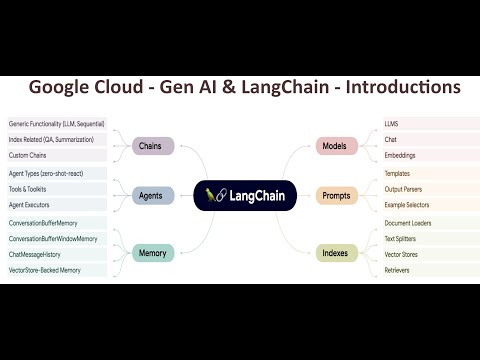


Transcript : there are three types of basic models  sorry I'm just scrolling up a little faster the the text the chat and then belly now we looked at the chat
Kewords: three types basic models sorry 'm scrolling little faster text chat belly looked chat 
 [MATCH : 48.3%]


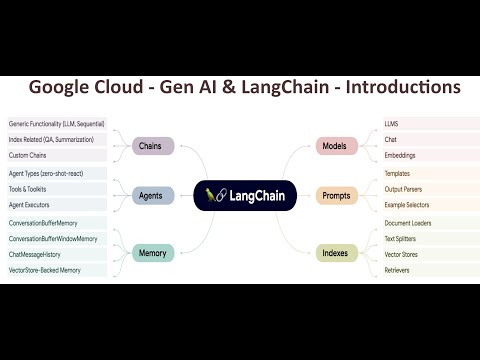


Transcript : next now let's look at the three  primitive models llms chat and text embeddings now llm remember this is the vertex AI text bison I'm going to ask which is the parent
Kewords: next let 's look three primitive models llms chat text embeddings llm remember vertex AI text bison 'm going ask parent 
 [MATCH : 46.1%]


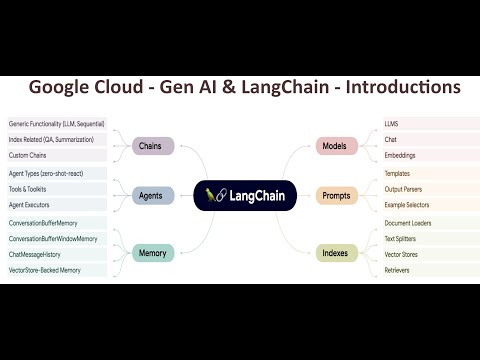


Transcript : the text pythons the chat bisons  and bearings the text embedding gecko templates we're gonna talk about prompt templates too we are going to talk about templates that you would create how you could chain prompts and things like that
Kewords: text pythons chat bisons bearings text embedding gecko templates 're gon na talk prompt templates going talk templates would create could chain prompts things like 
 [MATCH : 44.0%]


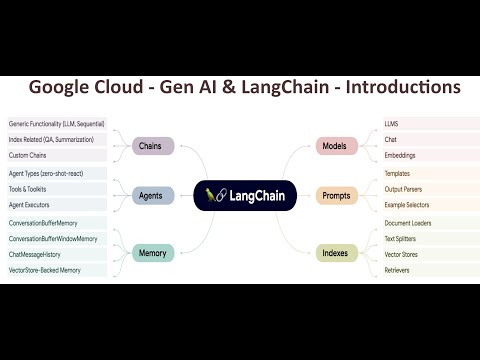

In [16]:
#@title Run this to locate the answer in video
question = "How many models are supported from Model Garden in LangChain?"# @param {type:"string"}

jumpto_timestamps(video_id, question)